In [1]:
## packages' import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

## WARNING

Theory requires the assumption of domain separability in most of the practical cases. 

## 1 : Penalty method for inverse problems

$Q$ and $U$ are euclidean balls

### non-separable components: 

example:: $f(x) = min_{u \in U}\, F(x) + \mathcal{F}(u) + \frac{\lambda}{2}||T_x\,x + T_u\,u- t||^2$

$t$ is $d_x$ dimensional

$T_x \in \mathbb{R}^{d_x\times d_x}$

$T_u \in \mathbb{R}^{d_x \times d_u}$ might be $\mathbf{0}$

$F \in \mathcal{S}^{1,1}_{\mu_x,L_x}(Q)$

$\mathcal{F} \in \mathcal{S}^{1,1}_{\mu_u,L_u}(U)$

case (1): bad aux, small dimension

case (2): good aux, big dimension

In [150]:
## dimensional set-up
pre_prop = 0.95
pre_d = 98
dx = int(np.ceil(pre_prop*pre_d)+2)
du = int(pre_d-dx+2)
d = dx+du

## size of domains 
delta_projections = 1e-6
advantage = 50 # neutral at 1
neutral = 0.1 # neutral at 1
H_Q = neutral*advantage
H_U = neutral
H_base = np.sqrt(H_Q**2 + H_U**2)

In [140]:
## basic functions

# construction of T_x (invertible required)
pre_pre_T_x = np.random.uniform(0,0.5,(dx,dx))
pre_T_x = pre_pre_T_x.T@pre_pre_T_x
T_x = pre_T_x + 0.001*np.eye(dx)
eigvals_x = np.real(np.linalg.eigvals(T_x.T@T_x))
biggest_x = np.max(eigvals_x)
smallest_x = np.min(eigvals_x)

# construction of T_u
T_u = np.random.uniform(0,1,(dx,du))
eigvals_u = np.real(np.linalg.eigvals(T_u.T@T_u))
biggest_u = np.max(eigvals_u)
smallest_u = np.min(eigvals_u)

# construction of T
T = np.block([[T_x.T@T_x,T_x.T@T_u],[T_u.T@T_x,T_u.T@T_u]])

# factice choice of minimizer
t = np.random.normal(0,1,dx)
u_opt = np.random.uniform(-5,5,du)
x_opt = np.linalg.solve(T_x,t-T_u@u_opt)
x_opt_no_Tu = np.linalg.solve(T_x,t)

# biggest eigenvalue of sym' matrix, computed efficiently 
eigvals = np.real(np.linalg.eigvals(T))
biggest = np.max(eigvals)
smallest = np.min(eigvals)

# lambda param for regularization (lambda should grow until a very large value but)
lambda_param = 5/biggest

# construction of F
mu_F = 0.001
L_F = 1
mu_x_practice = mu_F
L_x_practice = L_F + lambda_param*biggest_x
kappa_x_practice = mu_x_practice/L_x_practice

# construction of F_bis
mu_F_bis = 0.00
L_F_bis = 1
mu_u_practice = mu_F_bis
L_u_practice = L_F_bis + lambda_param*biggest_u
kappa_u_practice = mu_u_practice/L_u_practice
kappa_u_practice_cheat = (mu_u_practice+lambda_param*smallest_u)/L_u_practice

L_base_F_F_bis = np.max([L_F,L_F_bis])
L_base_practice = L_base_F_F_bis+lambda_param*biggest
mu_base_F_F_bis = np.min([mu_F,mu_F_bis])
mu_base_practice = mu_base_F_F_bis
mu_base_practice_advantageous = mu_base_F_F_bis+lambda_param*smallest
kappa_base_practice = mu_base_practice/L_base_practice

In [141]:
kappa_base_practice

0.0

In [142]:
kappa_x_practice

0.00016666679664145977

In [121]:
## oracle cost model (FGD used to solve inner problem)
oracle_K,oracle_beta,oracle_r = dx,du*H_U*np.sqrt(2*L_u_practice),1/2
oracle_cost = lambda eta: np.sum(oracle_K + oracle_beta/eta**oracle_r)
oracle_np_K,oracle_np_beta,oracle_np_r = d,0,1
oracle_np_cost = lambda eta: len(eta)*oracle_np_K

## delta cost model
delta_h,delta_s = 1/2 * np.sqrt(8*H_U**2*L_u_practice), 1/2
delta_cost = lambda eta: delta_h/delta_s * eta**delta_s
delta_np_h,delta_np_s = 0,1
delta_np_cost = lambda eta: delta_np_h/delta_np_s * eta**delta_np_s

In [130]:
## solve (I)

def solve_I_instance1_constant(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,mode='GD',disp=False,debug=False):
    
    feasible = True
    
    N = int(N_float)
    
    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
        else:
            q = np.ones(N)/N
        convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N]) 
        
    delta_cost = lambda eta: h/s * eta**s
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta))
    
    if Gamma_N_eps>min_delta:
        
        eta_schedule = (Gamma_N_eps/np.sum(q) * s/h)**(1/s) * np.ones(N)
    
        if disp:
            print('KKT solved:: Na = 0, Nb = 0')
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
        
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

def solve_I_instance1(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,mode='GD',disp=False,debug=False):
    
    feasible = True
    
    N = int(N_float)

    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
        else:
            q = np.ones(N)/N
        convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
    
    delta_cost = lambda eta: h/s * eta**s
    Phi = lambda Na,Nb: np.sum(delta_cost(lb)*q[:Nb]) + np.sum(delta_cost(la)*q[N+1-Na:]) 
    Psi = lambda Na,Nb: np.sum(h/s*(r*beta/h)**(s/(r+s))*q[Nb:N-Na]**(r/(r+s)))
    bar_lambda = lambda Na,Nb: ((Gamma_N_eps - Phi(Na,Nb))/Psi(Na,Nb))**(-(r+s)/s)
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta))
    
    trivial = True
    
    if Gamma_N_eps>min_delta:
    
        # check KKT (start with Na = 0 in order to speed up things as in my cases, Na = 0 is the right choice)
        for Na in np.arange(N):
            for Nb in np.arange(N-Na):
                bar_lambda_proposal = bar_lambda(Na,Nb)
                check = True 
                if debug: 
                    print('Na = '+str(Na)+' || Nb = '+str(Nb))
                if Na>0:
                    check = check and bar_lambda_proposal>=(r*beta)/(q[N-Na]*h*la**(r+s))
                if Nb>0:
                    check = check and bar_lambda_proposal<=(r*beta)/(q[Nb-1]*h*lb**(r+s))
                check = check and bar_lambda_proposal<(r*beta)/(q[N-Na-1]*h*la**(r+s))
                check = check and bar_lambda_proposal>(r*beta)/(q[Nb]*h*lb**(r+s))
                if check:
                    trivial = False
                    Na_final,Nb_final,bar_lambda_final = Na,Nb,bar_lambda_proposal
                    if disp:
                        print('KKT solved:: Na = '+str(Na_final)+', Nb = '+str(Nb_final)+', bar lambda = '+str(bar_lambda_final))
                    break
            if check:
                break

        if trivial:
            if disp:
                print('trivial solution')
            eta_schedule =  np.ones(N)*lb
        else:
            eta_schedule = np.concatenate((np.ones(Nb)*lb,((r*beta)/(bar_lambda_final*q[Nb:N-Na]*h))**(1/(r+s)),np.ones(Na_final)*la))
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
    
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

def BF_I_instance1(method,cost,epsilon_target,kappa,L,R,beta,r,h,s,la,lb,mode='GD',debug=False):
    
    multi = 2
    
    N = 1
    init_cost = np.inf
    results_N,results_cost = [],[]
    feasible = False
    N_low,N_up = 1,np.inf
    
    while feasible==False:
        
        N*=2
        
        if method=='constant':
            _,feasible = solve_I_instance1_constant(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode)
        else:
            _,feasible = solve_I_instance1(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode)
            
        if debug:
            print('current N : '+str(N)+' , feasible ? '+str(feasible))
            
        if feasible:
            N_up = N
        else:
            N_low = N
            
    # bisection 
    
    slack = N_up-N_low
    
    while slack>2:
        
        N = (N_up+N_low)/2
        
        if method=='constant':
            _,feasible = solve_I_instance1_constant(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode)
        else:
            _,feasible = solve_I_instance1(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,)
            
        if debug:
            print('current N : '+str(N)+' , feasible ? '+str(feasible))
            
        if feasible:
            N_up = N
        else:
            N_low = N
            
        slack = N_up-N_low
    
    print('minimal N = '+str(N_up))
    N_start = int(N_up)
    N_stop = int(multi*N_up)
    
    for N in np.arange(N_start,N_stop+1):
        
        if method=='constant':
            eta_sched,feasible = solve_I_instance1_constant(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode)
        else:
            eta_sched,feasible = solve_I_instance1(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode)
    
        if feasible: # should be okay always though :) 
            new_cost = cost(eta_sched)
            results_N.append(N)
            results_cost.append(new_cost)
            if new_cost<=init_cost:
                init_cost = new_cost
                eta_sched_lock = eta_sched
                N_lock = N
                
    return eta_sched_lock,N_lock,np.array(results_N),np.array(results_cost)

def BF_I(epsilon_target,kappa,L,R,mode='FGD',debug=False):
    
    N = 1
    N_lock = N
    cond = True
    N_low,N_up = 1,np.inf
    
    while cond:
        
        N*=2
        
        if mode=='FGD':
            proposal = np.min([2*L*R**2/N**2,(1+np.sqrt(kappa))**(-(N-1))*L*R**2/2])
        else:
            if kappa>0:
                proposal = np.min([L*R**2 /(2*N),L*R**2 * (1-kappa)**N / 2*((1-(1-kappa)**N)/(kappa))])
            else:
                proposal = L*R**2 /(2*N)
            
        if debug:
            print('current N : '+str(N)+' , proposal = '+str(proposal))
            
        if proposal<epsilon_target:
            N_up = N
            cond = False
        else:
            N_low = N
            
    # bisection
    
    slack = N_up-N_low
    
    
    while slack>2:
        
        N = (N_up+N_low)/2
        
        if mode=='FGD':
            proposal = np.min([2*L*R**2/N**2,(1+np.sqrt(kappa))**(-(N-1))*L*R**2/2])
        else:
            if kappa>0:
                proposal = np.min([L*R**2 /(2*N),L*R**2 * (1-kappa)**N / 2*((1-(1-kappa)**N)/(kappa))])
            else:
                proposal = L*R**2 /(2*N)
        
        if proposal<epsilon_target:
            N_up = N
            cond = False
        else:
            N_low = N
            
        slack = N_up-N_low
        
    N_lock = int(N_up)
            
    return np.zeros(N_lock),N_lock

In [136]:
epsilon_target = 1e-5

eta_factice,N = BF_I(epsilon_target,kappa_base_practice,L_base_practice,H_base,'FGD')

In [132]:
eta_schedule,N_opt,res_N,res_cost = BF_I_instance1('adaptive',oracle_cost,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta,oracle_r,delta_h,delta_s,\
                        1e-17,2*L_u_practice*H_U**2,'GD',True);

eta_schedule_constant,N_opt_c,res_N_const,res_cost_const = BF_I_instance1('constant',oracle_cost,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta,oracle_r,delta_h,delta_s,\
                        1e-17,2*L_u_practice*H_U**2,'GD',True);

current N : 2 , feasible ? False
current N : 4 , feasible ? False
current N : 8 , feasible ? False
current N : 16 , feasible ? False
current N : 32 , feasible ? False
current N : 64 , feasible ? False
current N : 128 , feasible ? False
current N : 256 , feasible ? False
current N : 512 , feasible ? False
current N : 1024 , feasible ? False
current N : 2048 , feasible ? False
current N : 4096 , feasible ? False
current N : 8192 , feasible ? True
current N : 6144.0 , feasible ? True
current N : 5120.0 , feasible ? False
current N : 5632.0 , feasible ? False
current N : 5888.0 , feasible ? True
current N : 5760.0 , feasible ? True
current N : 5696.0 , feasible ? True
current N : 5664.0 , feasible ? True
current N : 5648.0 , feasible ? False
current N : 5656.0 , feasible ? True
current N : 5652.0 , feasible ? False
current N : 5654.0 , feasible ? False
minimal N = 5656.0
current N : 2 , feasible ? False
current N : 4 , feasible ? False
current N : 8 , feasible ? False
current N : 16 , feas

In [137]:
# compute costs
print('optimal N constant : '+str(N_opt_c)+' for a total cost of '+str(oracle_cost(eta_schedule_constant)))
print('optimal N          : '+str(N_opt)+' for a total cost of '+str(oracle_cost(eta_schedule)))
print('optimal N          : '+str(N)+' for a total cost of '+str(oracle_np_cost(eta_factice)))

optimal N constant : 7190 for a total cost of 3130684543.108861
optimal N          : 9539 for a total cost of 978149560.2187488
optimal N          : 5480 for a total cost of 10970960


<IPython.core.display.Javascript object>


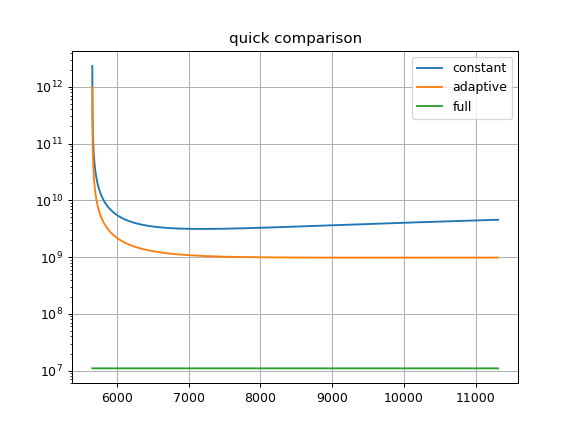

In [138]:
plt.figure()
plt.grid()
plt.title('quick comparison')
plt.semilogy(res_N_const,res_cost_const)
plt.semilogy(res_N,res_cost)
plt.semilogy(res_N,np.ones(len(res_N))*oracle_np_cost(eta_factice))
plt.legend(['constant','adaptive','full']);

In [ ]:
## oracle cost model (FGD used to solve inner problem)
oracle_K,oracle_beta = dx+du*np.log(L_u_practice*H_U**2/2)/np.log(1+np.sqrt(kappa_u_practice)),du/np.log(1+np.sqrt(kappa_u_practice))
oracle_cost = lambda eta: np.sum(oracle_K - oracle_beta*np.log(eta))
oracle_np_K,oracle_np_beta,oracle_np_r = d,0,1
oracle_np_cost = lambda eta: len(eta)*oracle_np_K

## delta cost model
delta_h,delta_s = 1/2 * np.sqrt(8*H_Q**2*L_u_practice), 1/2
delta_cost = lambda eta: delta_h/delta_s * eta**delta_s
delta_np_h,delta_np_s = 0,1
delta_np_cost = lambda eta: delta_np_h/delta_np_s * eta**delta_np_s

### greedy for complex sets

## 2 : Stackelberg in game theory 

$Q$ will be the simplex set whereas $U$ will denote a norm-ball

## 3 : Progressive gradient in large scale deterministic optimization

no restriction